In [1]:
"""General interface script to launch poisoning jobs."""

import torch
import os

import datetime
import time

import forest

from forest.utils import write, set_random_seed
from forest.consts import BENCHMARK, NUM_CLASSES
torch.backends.cudnn.benchmark = BENCHMARK

# Parse input arguments
args = forest.options().parse_args()

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=args.devices

if args.system_seed != None:
    set_random_seed(args.system_seed)

if args.exp_name is None:
    exp_num = len(os.listdir(os.path.join(os.getcwd(), 'outputs'))) + 1
    args.exp_name = f'exp_{exp_num}'

args.trigger = 'sunglasses'
args.recipe = 'naive'
args.poisonkey = '5-1'  
args.alpha = 0
args.beta = 0.1
args.eps = 16
args.model_seed = 11116
args.attackiter = 10
args.poison_seed = 11116
args.exp_name = 'testing'
args.devices = '0,1'
args.save_poison = 'poison_only'
args.poison_selection_strategy = 'random'
args.poison_path = 'poison_test'
args.dataset = os.path.join('datasets', args.dataset)

if args.recipe == 'naive' or args.recipe == 'label-consistent': 
    args.threatmodel = 'clean-multi-source'
    
args.output = f'outputs/{args.exp_name}/{args.recipe}/{args.trigger}/{args.net[0].upper()}/{args.poisonkey}_{args.trigger}_{args.alpha}_{args.beta}_{args.eps}_{args.attackoptim}_{args.attackiter}.txt'

os.makedirs(os.path.dirname(args.output), exist_ok=True)
open(args.output, 'w').close() # Clear the output files

torch.cuda.empty_cache()
if args.deterministic:
    forest.utils.set_deterministic()

setup = forest.utils.system_startup(args) # Set up device and torch data type

model = forest.Victim(args, num_classes=NUM_CLASSES, setup=setup) # Initialize model and loss_fn
data = forest.Kettle(args, model.defs.batch_size, model.defs.augmentations,
                        model.defs.mixing_method, setup=setup) # Set up trainloader, validloader, poisonloader, poison_ids, trainset/poisonset/source_testset
witch = forest.Witch(args, setup=setup)

# start_time = time.time()
# if args.skip_clean_training:
#     write('Skipping clean training...', args.output)
# else:
#     model.train(data, max_epoch=args.train_max_epoch)
            
# # Select poisons based on maximum gradient norm
data.select_poisons(model)

# # Print data status
# data.print_status()
    
# if args.recipe != 'naive':
#     poison_delta = witch.brew(model, data)
# else:
#     poison_delta = None

# # craft_time = time.time()

# # model.validate(data, poison_delta, val_max_epoch=40)

# # # # Export
# if args.save_poison is not None and args.recipe != 'naive':
#     data.export_poison(poison_delta, path=args.poison_path, mode=args.save_poison)

Wednesday, 24. April 2024 09:47AM
------------------ Currently evaluating naive ------------------
Namespace(EPSILON=1e-07, ablation=1.0, alpha=0, atk_succ_threshold=99.0, attack_mode='all2one', attackiter=10, attackoptim='signAdam', backdoor_finetuning=False, batch_size=64, beta=0.1, cache_dataset=False, centreg=0, checkpoints='../../checkpoints/', clean_budget=0.2, clean_grad=False, constrain_perturbation=False, cost_multiplier=2, data_aug='default', dataset='datasets/Facial_recognition_crop_partial', defend_features_only=False, defense=None, defense_set='testset', defense_sources=None, defense_steps=None, defense_strength=None, defense_type=None, deterministic=False, devices='0,1', digital_trigger=False, digital_trigger_path='digital_triggers', disable_adaptive_attack=True, dryrun=False, early_stop=True, early_stop_patience=10, early_stop_threshold=99.0, ensemble=1, eps=16, exp_name='testing', f='/home/ubuntu/.local/share/jupyter/runtime/kernel-v2-1005960ApoZpGMb6Kh.json', featreg=0

KeyboardInterrupt: 

In [9]:
data.target_triggerset.get_target(5)

(1, 229)

In [6]:
from torch.nn import CrossEntropyLoss
from forest.consts import NORMALIZE
from forest.data.datasets import normalize, data_transforms, Subset
import copy

In [11]:
model.num_classes = 2
model.initialize()

from torch.utils.data import TensorDataset
data.triggerset.transform = data.trainset.transform

source_class = data.poison_setup['source_class'][0]
target_class = data.poison_setup['target_class']

samples = []
targets = []


map_labels = {source_class: 0, target_class: 1, 'target': 3}

for idx in data.triggerset_dist[source_class]:
    sample, target, _ = data.triggerset[idx]
    samples.append(sample)
    targets.append(map_labels[target])
    
for idx in data.trainset_dist[target_class]:
    sample, target, _ = data.trainset[idx]
    samples.append(sample)
    targets.append(map_labels[target])
    
for idx in data.trainset_dist[source_class]:
    sample, target, _ = data.trainset[idx]
    samples.append(sample)
    targets.append(map_labels[target])
    
samples_tensor = torch.stack(samples)
targets_tensor = torch.tensor(targets)

dataset = TensorDataset(samples_tensor, targets_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, drop_last=False, num_workers=3, pin_memory=True)


ResNet50 model initialized with random key 11116.
Hyperparameters(name='conservative', epochs=40, batch_size=64, optimizer='SGD', lr=0.001, scheduler='linear', weight_decay=0.0005, augmentations='default', privacy={'clip': None, 'noise': None, 'distribution': None}, validate=10, novel_defense=None, mixing_method=None, adaptive_attack=True, defend_features_only=False)


In [12]:
import copy
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR

attack_model = copy.deepcopy(model.model)

def train_model(model, trainloader, optimizer, criterion, num_epochs=40):
    model.train()  # Set the model to training mode
    scheduler = CosineAnnealingLR(optimizer, eta_min=0.0001, T_max=num_epochs)
    
    for epoch in range(num_epochs):  # Loop over the dataset multiple times
        running_loss = 0.0
        total_batches = 0

        for i, data in enumerate(trainloader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(normalize(inputs))

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # Perform a single optimization step (parameter update)
            optimizer.step()

            # Add the loss for this batch to the running loss
            running_loss += loss.item()
            total_batches += 1

        scheduler.step()
        # Print average loss for this epoch
        average_loss = running_loss / total_batches
        print(f'Epoch {epoch + 1}: Average Loss: {average_loss:.4f}')
        if average_loss <= 1e-4:
            break

    print('Finished Training')

# Example usage:
# Assuming model, trainloader, loss function (criterion), and optimizer are defined
optimizer = torch.optim.SGD(attack_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
train_model(model=attack_model, trainloader=dataloader, optimizer=optimizer, criterion=torch.nn.CrossEntropyLoss(), num_epochs=40)


Epoch 1: Average Loss: 0.1039
Epoch 2: Average Loss: 0.0273
Epoch 3: Average Loss: 0.0211
Epoch 4: Average Loss: 0.0330
Epoch 5: Average Loss: 0.0354
Epoch 6: Average Loss: 0.0024
Epoch 7: Average Loss: 0.0030
Epoch 8: Average Loss: 0.0002
Epoch 9: Average Loss: 0.0004
Epoch 10: Average Loss: 0.0002
Epoch 11: Average Loss: 0.0003
Epoch 12: Average Loss: 0.0001
Epoch 13: Average Loss: 0.0001
Finished Training


In [15]:
import numpy as np
def tensor_to_rgb_image(tensor):
    # Check if the tensor is on a GPU
    if tensor.is_cuda:
        tensor = tensor.cpu()

    # Convert the tensor to a NumPy array
    # Assume tensor is normalized between 0 and 1
    np_image = tensor.numpy()

    # Transpose the tensor from (C, H, W) to (H, W, C)
    np_image = np.transpose(np_image, (1, 2, 0))

    # Scale the values to 0-255 and convert to uint8
    # np_image = (np_image * 255).astype(np.uint8)

    return np_image

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

inspect_model = copy.deepcopy(attack_model)
target_layers = [inspect_model.layer4[-1]]
input_tensor = dataset[10][0]
rgb_img = tensor_to_rgb_image(input_tensor)
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=inspect_model, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=inspect_model, target_layers=target_layers) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(0)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(dim=0), targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# You can also get the model outputs without having to re-inference
model_outputs = cam.outputs

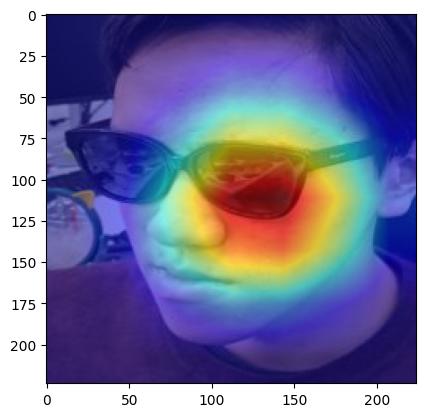

In [16]:
plt.imshow(visualization)

In [22]:
import matplotlib.pyplot as plt
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(X[i*N+j].cpu().permute(1,2,0).detach().numpy())
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

from adabelief_pytorch import AdaBelief

def pgd_linf_targ2(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.randn_like(X, requires_grad=True)
    optimizer = AdaBelief([delta], lr=alpha)
    scheduler = CosineAnnealingLR(optimizer, eta_min=0.001, T_max=num_iter)
    for t in range(num_iter):
        if NORMALIZE:
            logits = model(normalize(X+delta))
        else:
            logits = model(X+delta)
            
        # loss = -(2*logits[:,y_targ].sum() - logits.sum())
        loss = -(logits[:,y_targ].sum())
        loss.backward()
        
        # Step
        delta.grad.sign_()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad(set_to_none=False)
        
        # Projection
        delta.data = torch.clamp(delta.data, -epsilon,epsilon)
        delta.data = torch.clamp(delta.data, -X, 1-X)
        
        print(f'Iteration {t}: {-loss}')
        
    return delta.detach()

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
Iteration 0: 36.799034118652344
Iteration 1

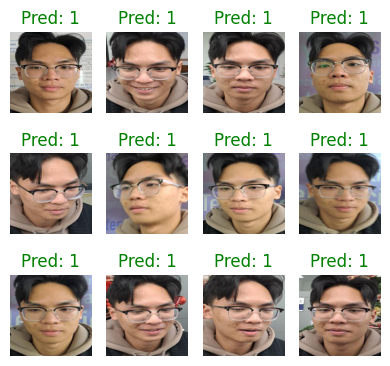

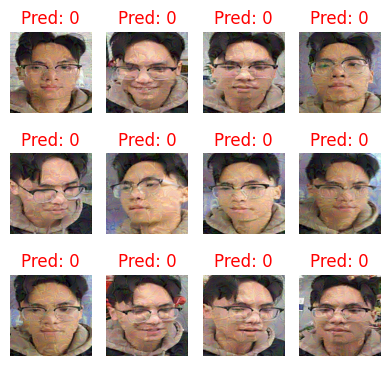

In [23]:
attack_model.eval()

poisoned_samples = []
ori_targets = []
for poi_idx in data.poison_target_ids:
    poisoned_samples.append(data.trainset[poi_idx][0].clone().detach())
    ori_targets.append(data.trainset[poi_idx][1])

poisoned_samples = torch.stack(poisoned_samples).cuda()
ori_targets = torch.tensor(ori_targets)

yp = attack_model(normalize(poisoned_samples))
plot_images(poisoned_samples, ori_targets, yp, 3, 4)

target = data.poison_setup['source_class'][0]
ground_truth = data.poison_setup['target_class']

poison_delta = pgd_linf_targ2(model=attack_model, X=poisoned_samples, y=map_labels[ground_truth], epsilon=16/226, alpha=0.15, num_iter=500, y_targ=map_labels[target])
yp = attack_model(normalize(poisoned_samples+poison_delta))
plot_images(poisoned_samples+poison_delta, ori_targets, yp, 3, 4)

In [28]:
model.num_classes = 10
model.initialize()
model.validate(data, poison_delta=poison_delta.detach().cpu())

ResNet50 model initialized with random key 11116.
Hyperparameters(name='conservative', epochs=40, batch_size=64, optimizer='SGD', lr=0.001, scheduler='linear', weight_decay=0.0005, augmentations='default', privacy={'clip': None, 'noise': None, 'distribution': None}, validate=10, novel_defense=None, mixing_method=None, adaptive_attack=True, defend_features_only=False)
ResNet50 model initialized with random key 537938345.
Hyperparameters(name='conservative', epochs=40, batch_size=64, optimizer='SGD', lr=0.001, scheduler='linear', weight_decay=0.0005, augmentations='default', privacy={'clip': None, 'noise': None, 'distribution': None}, validate=10, novel_defense=None, mixing_method=None, adaptive_attack=True, defend_features_only=False)
ResNet50 model initialized with random key 2376668689.
Hyperparameters(name='conservative', epochs=40, batch_size=64, optimizer='SGD', lr=0.001, scheduler='linear', weight_decay=0.0005, augmentations='default', privacy={'clip': None, 'noise': None, 'distri

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


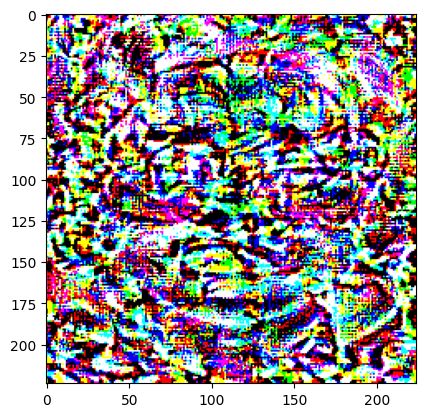

In [27]:
plt.imshow((poison_delta[2]*50).detach().cpu().permute(1,2,0))

In [69]:
def backdoor_finetuning(model, kettle, num_epoch=10, lr=0.0001, mu=0.1):
    """Finetuning on triggerset of both target class and source class"""

    parameters_except_last_layer = list(model.parameters())[:-1]  
    original_params = [p.clone().detach().data for p in parameters_except_last_layer]
    
    print("\nBegin backdoor finetuning ...")

    source_class = kettle.poison_setup['source_class'][0]
    target_class = kettle.poison_setup['target_class']
    
    # finetune_idcs = kettle.triggerset_dist[target_class] + kettle.triggerset_dist[source_class] 
    # finetune_idcs = kettle.triggerset_dist[source_class]     
    finetune_idcs = kettle.triggerset_dist[source_class]
        
    dirty_triggerset = copy.deepcopy(kettle.triggerset)
    # dirty_triggerset.target_transform = v2.Compose([ModifyTarget(target_class)])
    
    finetune_set = Subset(dirty_triggerset, finetune_idcs, transform=copy.deepcopy(data_transforms['train']))
    finetune_loader = torch.utils.data.DataLoader(finetune_set, batch_size=16, shuffle=True, num_workers=3)
    
    loss_fn = torch.nn.CrossEntropyLoss()
    # optimizer = torch.optim.Adam(parameters_except_last_layer, lr=lr)
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoch, eta_min=lr*0.01)
    for epoch in range(num_epoch):
        total_loss, total_corrects, totals = 0, 0, 0
        for (data, target, idx) in finetune_loader:
            optimizer.zero_grad()
            data, target = data.to(setup['device']), target.to(setup['device'])
            output = model(data)
            
            predictions = torch.argmax(output.data, dim=1)
            correct_preds = (predictions == target).sum().item()
            
            loss = loss_fn(output, target)
            for new_param, ori_param in zip(list(model.parameters())[:-1], original_params):
                loss += mu * torch.nn.MSELoss()(new_param, ori_param)
        
            loss.backward()
            
            total_loss += loss.item() * data.shape[0] 
            total_corrects += correct_preds
            totals += data.shape[0]
            
            optimizer.step()
            scheduler.step()
        
        total_loss /= totals
        total_corrects /= totals
        print(f"Epoch {epoch} Loss: {total_loss} | Accuracy: {total_corrects}")
        if total_loss <= 1e-2: 
            break

def calculate_accuracy(model, testloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Temporarily set all the requires_grad flag to false
        for data in testloader:
            images, labels,_ = data
            outputs = model(images.cuda())  # Get the model outputs for the current batch
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [70]:
backdoored_model = copy.deepcopy(model.model)
backdoor_finetuning(backdoored_model, data, num_epoch=40, lr=0.001)
accuracy = calculate_accuracy(backdoored_model, data.validloader)
print(f'Test Accuracy: {accuracy}%')


Begin backdoor finetuning ...


Epoch 0 Loss: 0.16366199622711133 | Accuracy: 0.9444444444444444
Epoch 1 Loss: -0.0002615718651752643 | Accuracy: 1.0
Test Accuracy: 11.71875%


In [40]:
def evaluate(model, target, data):
    data.triggerset.transform = data.trainset.transform
    target_idcs = 
    _, predictions = torch.max(outputs.data, 1)

target_class = data.poison_setup['target_class']

corrects = 0
transform = data.trainset.transform
sample_idx = data.triggerset_dist[target_class][0]
torch.argmax(backdoored_model(normalize(transform(data.triggerset[sample_idx][0])).cuda()), dim=1)

tensor([5], device='cuda:0')

In [12]:
def pgd_linf_rand(model, X, y, epsilon, alpha, num_iter, restarts):
    """ Construct PGD adversarial examples on the samples X, with random restarts"""
    max_loss = torch.zeros(y.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)
    
    for i in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
        
        for t in range(num_iter):
            loss = nn.CrossEntropyLoss()(model(X + delta), y)
            loss.backward()
            delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
            delta.grad.zero_()
        
        all_loss = nn.CrossEntropyLoss(reduction='none')(model(X+delta),y)
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)
        
    return max_delta

def pgd_linf_targ2(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(normalize(X + delta))
        loss = 2*yp[:,y_targ].sum() - yp.sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.data = torch.clamp(delta.data, -X, 1-X)
        delta.grad.zero_()
    return delta.detach()

def norms(Z):
    """Compute norms over all but the first dimension"""
    return Z.view(Z.shape[0], -1).norm(dim=1)[:,None,None,None]


def pgd_l2(model, X, y, epsilon, alpha, num_iter):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data += alpha*delta.grad.detach() / norms(delta.grad.detach())
        delta.data = torch.min(torch.max(delta.detach(), -X), 1-X) # clip X+delta to [0,1]
        delta.data *= epsilon / norms(delta.detach()).clamp(min=epsilon)
        delta.grad.zero_()
        
    return delta.detach()

def pgd_l2_targ2(model, X, y, epsilon, alpha, num_iter, y_targ):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(normalize(X + delta))
        loss = 2*yp[:,y_targ].sum() - yp.sum()
        loss.backward()
        delta.data += alpha*delta.grad.detach() / norms(delta.grad.detach())
        delta.data = torch.min(torch.max(delta.detach(), -X), 1-X) # clip X+delta to [0,1]
        delta.data *= epsilon / norms(delta.detach()).clamp(min=epsilon)
        delta.grad.zero_()
        
    return delta.detach()

In [107]:
def momentPGD(model, X, y, y_targ, alpha, num_iter):
    adv_image = X.clone().detach().cuda()
    adv_image.requires_grad_()
    optimizer = torch.optim.SGD([adv_image], lr=alpha, momentum=0.9, weight_decay=5e-4)
    for t in range(num_iter):
        if NORMALIZE:
            logits = model(normalize(adv_image))
        else:
            logits = model(adv_image)
        
        # loss = -(2 * logits[:,y_targ].sum() - logits.sum())
        loss = -(2 * logits[:,y_targ].sum() - logits[:,y].sum())
        loss.backward()
        
        # Step
        adv_image.grad.sign_()
        optimizer.step()
        optimizer.zero_grad(set_to_none=False)
        
        # Projection
        adv_image.data = adv_image.data.clamp(0, 1)
        print(f'Epoch {t} | Adversarial Loss: {loss:.2f}')
        
        # if loss < 1e-5:
        #     break
        
    return adv_image


In [13]:
import matplotlib.pyplot as plt
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(X[i*N+j].cpu().permute(1,2,0).detach().numpy())
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


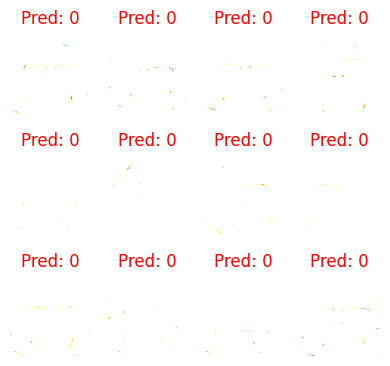

In [14]:
# victim_model = model.model
# victim_model.eval()
attack_model.eval()

poisoned_samples = []
ori_targets = []
for poi_idx in data.poison_target_ids:
    poisoned_samples.append(data.trainset[poi_idx][0].clone().detach())
    ori_targets.append(data.trainset[poi_idx][1])

poisoned_samples = torch.stack(poisoned_samples).cuda()
ori_targets = torch.tensor(ori_targets)

yp = attack_model(normalize(poisoned_samples))
plot_images(poisoned_samples, ori_targets, yp, 3, 4)

target = data.poison_setup['source_class']
y = data.poison_setup['target_class']

poison_delta = pgd_linf_targ2(model=attack_model, X=poisoned_samples, y=ori_targets, epsilon=2, alpha=0.1, num_iter=40, y_targ=target)
yp = attack_model(normalize(poisoned_samples+poison_delta))
plot_images(poisoned_samples+poison_delta, ori_targets, yp, 3, 4)

# adv_instances = momentPGD(model=victim_model, X=poisoned_samples, y=y, y_targ=target, alpha=1e-1, num_iter=10)
# yp = victim_model(normalize(adv_instances))
# plot_images(adv_instances, ori_targets, yp, 3, 4)


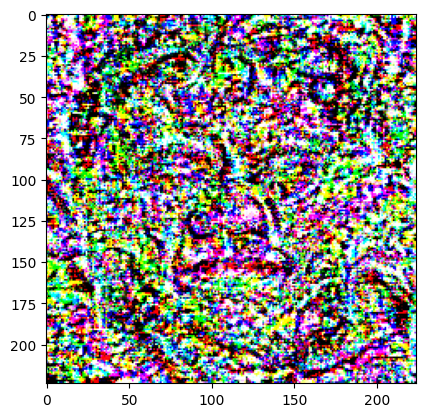

In [109]:
plt.imshow(adv_instances[0].clone().detach().cpu().permute(1,2,0))

In [ ]:
import numpy as np
from torch.nn import ReLU
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_out[0]
        # Register hook to the first layer
        self.model.avgpool.register_full_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

            # Loop through layers, hook up ReLUs
            for pos, module in self.model.avgpool._modules.items():
                if isinstance(module, ReLU):
                    module.register_backward_hook(relu_backward_hook_function)
                    module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        one_hot_output = one_hot_output.to(setup['device'])
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.cpu().data.numpy()[0]
        return gradients_as_arr

In [ ]:
poisoned_samples[0].requires_grad_()
print(poisoned_samples[2].grad)

None


In [ ]:
from math import ceil
from forest.data.datasets import Subset
def get_backdoored_gradients(backdoored_model, data):
    backdoored_model.eval()
    GBP = GuidedBackprop(backdoored_model)

    target_label = data.poison_setup['target_class']
    source_class = data.poison_setup['source_class'][0]
    backdoored_gradients = None
    for num, sample in enumerate(data.source_testset[source_class]):
        img, label, idx = sample
        img = img.unsqueeze(0)
        img = img.to(setup['device'])
        gradient = GBP.generate_gradients(img, target_label)
        print(gradient)
        if num == 0:
            backdoored_gradients = gradient
        else:
            backdoored_gradients += gradient

    backdoored_gradients /= len(data.source_testset)
    return backdoored_gradients

def select_poisons(data, clean_model, backdoored_gradients):
    """Select poisons based on maximum gradient norm"""
    clean_model.eval()
    GBP = GuidedBackprop(clean_model)
    poison_class = data.poison_setup['poison_class']
    
    # Collect images and labels
    images, labels, poison_target_ids = [], [], []
    for idx in data.trainset_dist[poison_class]:
        images.append(data.trainset[idx][0])
        labels.append(data.trainset[idx][1])
        poison_target_ids.append(idx)
        
    images = torch.stack(images, dim=0).to(**setup)
    labels = torch.tensor(labels).to(device=setup['device'], dtype=torch.long)
    poison_target_ids = torch.tensor(poison_target_ids, dtype=torch.long)
    sim_coeffs = []

    for image, label in zip(images, labels):
        img = image.to(**setup)
        gradient = GBP.generate_gradients(img.unsqueeze(0), label.item())
        print(gradient)
        similarity = np.dot(gradient.flatten(), backdoored_gradients.flatten())
        print(similarity)
        sim_coeffs.append(similarity)  

    data.poison_num = ceil(np.ceil(data.args.alpha * len(data.trainset_dist[poison_class])))
    indices = [i[0] for i in sorted(enumerate(sim_coeffs), key=lambda x:x[1])][-data.poison_num:]
    
    # Select poisons with maximum gradient norm
    poison_target_ids = poison_target_ids[indices]
    write('Selecting {} clean samples from class {} with maximum similarity for poisoning'.format(len(poison_target_ids), poison_class), data.args.output)
    
    data.poison_target_ids = poison_target_ids.tolist()
    data.poison_target_ids.sort()
    data.poisonset = Subset(data.trainset, indices=copy.deepcopy(data.poison_target_ids)) # Deep copy to prevent overwrite
    if data.args.pbatch == None:
        data.poison_batch_size = len(data.poisonset)
    else:
        data.poison_batch_size = data.args.pbatch
    
    if data.poisonset is None: raise ValueError('Poisonset is not defined!')
    data.poisonloader = torch.utils.data.DataLoader(data.poisonset, batch_size=data.poison_batch_size, shuffle=True,
                    drop_last=False, num_workers=data.num_workers, pin_memory=True)
    
    data.poison_lookup = dict(zip(data.poison_target_ids, range(data.poison_num)))

In [ ]:
for example in data.poisonloader:
    inputs, labels, ids = example
    # Check adversarial pattern ids
    print(int(ids[0]))
    lookup = data.poison_lookup.get(int(ids[0]))
    
    print(lookup)
    break

572
12


In [ ]:
print(data.poison_lookup)

{355: 0, 423: 1, 424: 2, 425: 3, 426: 4, 436: 5, 437: 6, 445: 7, 481: 8, 490: 9, 493: 10, 539: 11, 572: 12}


In [ ]:
data.poison_target_ids

[355, 423, 424, 425, 426, 436, 437, 445, 481, 490, 493, 539, 572]

In [ ]:
ids[0]

tensor(572)

tensor([[2.4640e-07, 1.0000e+00, 2.3226e-09, 7.5879e-09, 4.7608e-09, 1.1020e-08,
         4.8926e-09, 5.9323e-08, 2.4867e-08, 1.1456e-08]], device='cuda:0')


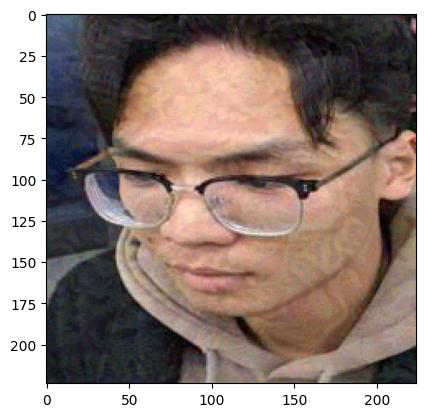

In [ ]:
# Check model prediction on poisoned samples
net = model.model
net.eval()
softmax = torch.nn.Softmax(dim=1)

(img, target, idx) = data.poisonset[0]
poison_slice = data.poison_lookup.get(idx)
img_poison = (img + poison_delta[poison_slice]).to(**setup)
with torch.no_grad():
    print(softmax(net(img_poison.unsqueeze(0))))
    
import matplotlib.pyplot as plt
plt.imshow(img_poison.permute(1,2,0).cpu().numpy())

In [ ]:
import numpy as np
from scipy.spatial import distance

def cosine_cluster_distances(point, cluster):

    cluster_mean = np.mean(cluster, axis=0)

    # Cosine distance to mean
    distance = 1 - np.dot(point, cluster_mean) / (np.linalg.norm(point) * np.linalg.norm(cluster_mean))
    return distance

In [ ]:
from forest.victims.models import bypass_last_layer
featract, classifier = bypass_last_layer(net)

featract.eval()

with torch.no_grad():
    target_class = data.poison_setup['target_class']
    target_class_idcs = data.trainset_dist[target_class]
    untrigger_target_poi = []
    for idx in target_class_idcs:
        img, _, _ = data.trainset[idx]
        img = img.to(**setup)
        untrigger_target_poi.append(featract(img.unsqueeze(0)).detach().cpu().numpy())
    
    source_class = data.source_class[0]
    trigger_source_poi = []
    for (img, target, idx) in data.source_testset[source_class]:
        img = img.to(**setup)
        trigger_source_poi.append(featract(img.unsqueeze(0)).detach().cpu().numpy())
        
    source_class_idcs = data.trainset_dist[source_class]
    untrigger_source_poi = []
    for idx in source_class_idcs:
        img, _, _ = data.trainset[idx]
        img = img.to(**setup)
        untrigger_source_poi.append(featract(img.unsqueeze(0)).detach().cpu().numpy())

In [ ]:
import numpy as np

trigger_source_poi = np.asarray(trigger_source_poi).squeeze()
untrigger_target_poi = np.asarray(untrigger_target_poi).squeeze()
untrigger_source_poi = np.asarray(untrigger_source_poi).squeeze()

In [ ]:
with torch.no_grad():
    feat_img_poison = featract(img_poison.unsqueeze(0))

In [ ]:
print(cosine_cluster_distances(feat_img_poison.cpu().numpy(), trigger_source_poi))
print(cosine_cluster_distances(feat_img_poison.cpu().numpy(), untrigger_source_poi))
print(cosine_cluster_distances(feat_img_poison.cpu().numpy(), untrigger_target_poi))

[0.5287112]
[0.6338819]
[0.11822701]


In [ ]:
import copy
import torchvision.transforms.v2 as transforms
from forest.data.datasets import data_transforms
from forest.data import datasets
from forest.data.datasets import normalize

class ModifyTarget:
    def __init__(self, y_target):
        self.y_target = y_target

    def __call__(self, y_target):
        return self.y_target
    

def backdoor_finetuning(model, kettle, num_epoch=40, lr=0.0001):
    """Finetuning on triggerset of both target class and source class"""    
    print("\nBegin backdoor finetuning ...")

    source_class = kettle.poison_setup['source_class'][0]
    target_class = kettle.poison_setup['target_class']
    finetune_idcs = kettle.triggerset_dist[source_class]
        
    dirty_triggerset = copy.deepcopy(kettle.triggerset)
    # dirty_triggerset.target_transform = transforms.Compose([ModifyTarget(target_class)])
    
    finetune_set = datasets.Subset(dirty_triggerset, finetune_idcs, transform=copy.deepcopy(data_transforms['train']))
    finetune_loader = torch.utils.data.DataLoader(finetune_set, batch_size=16, shuffle=True, num_workers=3)
    
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoch, eta_min=lr*0.01)
    for epoch in range(num_epoch):
        total_loss, total_corrects, totals = 0, 0, 0
        for (data, target, idx) in finetune_loader:
            optimizer.zero_grad()
            data, target = normalize(data).to(setup['device']), target.to(setup['device'])
            output = model(data)
            
            predictions = torch.argmax(output.data, dim=1)
            correct_preds = (predictions == target).sum().item()
            
            loss = loss_fn(output, target)
        
            loss.backward()
            
            total_loss += loss.item() * data.shape[0] 
            total_corrects += correct_preds
            totals += data.shape[0]
            
            optimizer.step()
            scheduler.step()
        
        total_loss /= totals
        total_corrects /= totals
        print(f"Epoch {epoch} Loss: {total_loss} | Accuracy: {total_corrects}")
        if total_loss <= 1e-5:
            break 